In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, loadCIFAR10, plot_loss, plot_acc, plot_shifts, inference_time

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 3, 32, 32)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


## CIFAR10 LeNet

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

best_parameters = LeNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

{'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125} 69.994


In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Flatten: 2-9                      [100, 1024]               --
│    └─Linear: 2-10                      [100, 120]                123,000
│    └─Tanh: 2-11                        [100, 120]                --
│    └

In [6]:
PATH = "models/LeNet_Cifar/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.928
test_loss: 1.805, test_accuracy: 35.54
[1,   200] train_loss: 1.745
test_loss: 1.651, test_accuracy: 41.89
[1,   300] train_loss: 1.648
test_loss: 1.617, test_accuracy: 42.73
[1,   400] train_loss: 1.549
test_loss: 1.467, test_accuracy: 47.14
[1,   500] train_loss: 1.517
test_loss: 1.430, test_accuracy: 48.32
[2,   100] train_loss: 1.428
test_loss: 1.393, test_accuracy: 49.71
[2,   200] train_loss: 1.415
test_loss: 1.367, test_accuracy: 50.85
[2,   300] train_loss: 1.385
test_loss: 1.351, test_accuracy: 51.79
[2,   400] train_loss: 1.365
test_loss: 1.354, test_accuracy: 51.53
[2,   500] train_loss: 1.328
test_loss: 1.351, test_accuracy: 51.95
[3,   100] train_loss: 1.270
test_loss: 1.275, test_accuracy: 54.29
[3,   200] train_loss: 1.280
test_loss: 1.265, test_accuracy: 54.57
[3,   300] train_loss: 1.258
test_loss: 1.240, test_accuracy: 55.51
[3,   400] train_loss: 1.253
test_loss: 1.231, test_accuracy: 55.91
[3,   500] train_loss: 1.243
test_loss: 1.214, t

In [8]:
torch.save(LeNN, "./models/LeNet_Cifar/LeNet.pth")

In [4]:
LeNN = torch.load("./models/LeNet_Cifar/LeNet.pth")

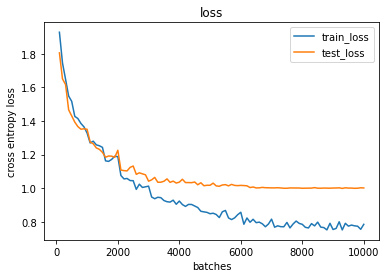

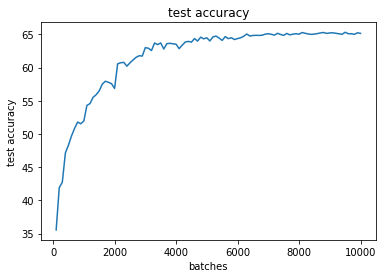

In [5]:
plot_loss(LeNN)
plot_acc(LeNN)

In [6]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeNN.train_time), 3)}")
print(f"std: {round(np.std(LeNN.train_time), 3)}")

Training time (s):
mean: 1.007
std: 0.172


In [7]:
inference_times = inference_time(LeNN, test_dataloader, device)
print("Inference time (ns)")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

0
2468750000
1
0
2
0
3
0
4
0
5
15625000
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
15625000
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
15625000
74
0
75
15625000
76
0
77
0
78
0
79
0
80
0
81
0
82
15625000
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0
Inference time (ns)
2.547e+07
2.5e+08


## CIFAR10 LeASLNet

In [4]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet_Cifar/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

{'lr': 0.026123046875, 'momentum': 0.928466796875, 'p_randomTransform': 0.00634765625} 70.484


In [5]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 16, 16]         112
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─

In [6]:
PATH = "models/LeNet_Cifar/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.936
test_loss: 1.715, test_accuracy: 38.6
[1,   200] train_loss: 1.648
test_loss: 1.531, test_accuracy: 44.56
[1,   300] train_loss: 1.505
test_loss: 1.469, test_accuracy: 47.09
[1,   400] train_loss: 1.450
test_loss: 1.427, test_accuracy: 48.01
[1,   500] train_loss: 1.405
test_loss: 1.371, test_accuracy: 50.54
[2,   100] train_loss: 1.337
test_loss: 1.341, test_accuracy: 51.12
[2,   200] train_loss: 1.348
test_loss: 1.346, test_accuracy: 51.16
[2,   300] train_loss: 1.330
test_loss: 1.346, test_accuracy: 52.32
[2,   400] train_loss: 1.297
test_loss: 1.275, test_accuracy: 54.07
[2,   500] train_loss: 1.285
test_loss: 1.273, test_accuracy: 54.93
[3,   100] train_loss: 1.235
test_loss: 1.278, test_accuracy: 54.44
[3,   200] train_loss: 1.226
test_loss: 1.298, test_accuracy: 53.75
[3,   300] train_loss: 1.229
test_loss: 1.307, test_accuracy: 52.8
[3,   400] train_loss: 1.195
test_loss: 1.227, test_accuracy: 56.09
[3,   500] train_loss: 1.216
test_loss: 1.226, tes

In [8]:
torch.save(LeASLNN, "./models/LeNet_Cifar/LeASLNet.pth")

In [8]:
LeASLNN = torch.load("./models/LeNet_Cifar/LeASLNet.pth")

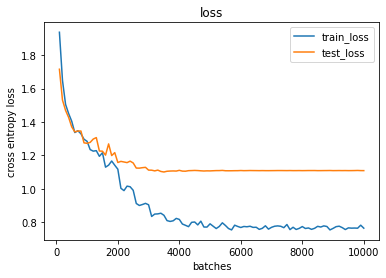

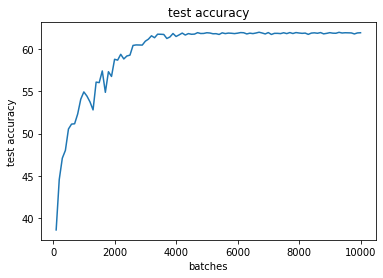

In [9]:
plot_loss(LeASLNN)
plot_acc(LeASLNN)

In [10]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeASLNN.train_time), 3)}")
print(f"std: {round(np.std(LeASLNN.train_time), 3)}")

Training time (s):
mean: 1.024
std: 0.178


In [11]:
inference_times = inference_time(LeASLNN, test_dataloader, device)
print("Inference time (ns)")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

0
406250000
1
0
2
0
3
15625000
4
0
5
0
6
0
7
0
8
0
9
15625000
10
0
11
0
12
0
13
15625000
14
0
15
15625000
16
0
17
0
18
0
19
15625000
20
0
21
0
22
0
23
0
24
15625000
25
15625000
26
0
27
0
28
15625000
29
0
30
0
31
0
32
15625000
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
15625000
49
15625000
50
0
51
0
52
0
53
0
54
0
55
0
56
15625000
57
15625000
58
0
59
0
60
0
61
15625000
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
15625000
73
0
74
0
75
0
76
15625000
77
0
78
0
79
0
80
15625000
81
0
82
0
83
0
84
0
85
15625000
86
0
87
15625000
88
0
89
0
90
0
91
0
92
15625000
93
0
94
0
95
0
96
15625000
97
0
98
0
99
0
Inference time (ns)
7.344e+06
4.1e+07


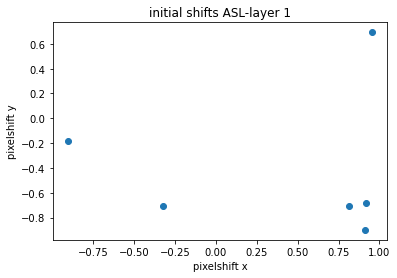

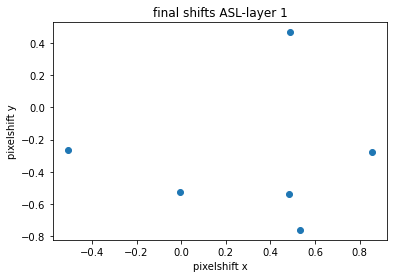

In [23]:
plot_shifts(LeASLNN)

## CIFAR10 LeDepthNet

In [8]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

best_parameters = LeDepthNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 76.096, 'lr': 0.03690704896414862, 'momentum': 0.7947779805241895, 'p_randomTransform': 0.00388878111128646}, {'acc': 69.042, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 68.756, 'lr': 0.08206054687499999, 'momentum': 0.6094042968750002, 'p_randomTransform': 0.70697265625}]


In [9]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Depth_wise_block: 2-5             [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─Tanh: 2-10                        [100, 120]                --
│    └─L

In [10]:
PATH = "models/LeNet_Cifar/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [11]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.032
test_loss: 1.814, test_accuracy: 33.61
[1,   200] train_loss: 1.720
test_loss: 1.637, test_accuracy: 39.81
[1,   300] train_loss: 1.582
test_loss: 1.535, test_accuracy: 44.45
[1,   400] train_loss: 1.497
test_loss: 1.421, test_accuracy: 48.84
[1,   500] train_loss: 1.422
test_loss: 1.397, test_accuracy: 49.44
[2,   100] train_loss: 1.370
test_loss: 1.350, test_accuracy: 51.38
[2,   200] train_loss: 1.349
test_loss: 1.333, test_accuracy: 51.7
[2,   300] train_loss: 1.344
test_loss: 1.350, test_accuracy: 51.26
[2,   400] train_loss: 1.329
test_loss: 1.291, test_accuracy: 52.67
[2,   500] train_loss: 1.305
test_loss: 1.263, test_accuracy: 54.06
[3,   100] train_loss: 1.259
test_loss: 1.247, test_accuracy: 55.0
[3,   200] train_loss: 1.249
test_loss: 1.342, test_accuracy: 51.57
[3,   300] train_loss: 1.218
test_loss: 1.244, test_accuracy: 55.34
[3,   400] train_loss: 1.221
test_loss: 1.223, test_accuracy: 56.02
[3,   500] train_loss: 1.222
test_loss: 1.206, tes

In [12]:
torch.save(LeDepthNN, "./models/LeNet_Cifar/LeDepthNet.pth")

In [12]:
LeDepthNN = torch.load("./models/LeNet_Cifar/LeDepthNet.pth")

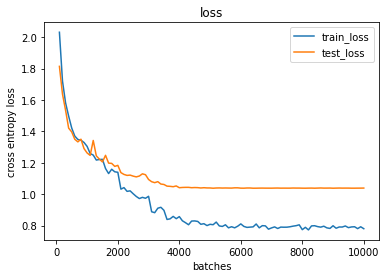

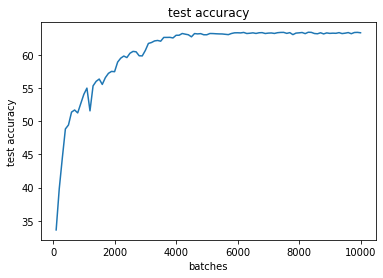

In [13]:
plot_loss(LeDepthNN)
plot_acc(LeDepthNN)

In [14]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeDepthNN.train_time), 3)}")
print(f"std: {round(np.std(LeDepthNN.train_time), 3)}")

Training time (s):
mean: 0.82
std: 0.145


In [15]:
inference_times = inference_time(LeDepthNN, test_dataloader, device)
print("Inference time (ns)")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

0
0
1
0
2
0
3
15625000
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
15625000
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
15625000
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
15625000
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0
Inference time (ns)
6.250e+05
3.1e+06
